### Import Python packages


In [1]:
import macrosynergy
import pandas as pd
import numpy as np
import polars as pl
import os
import time

from macrosynergy.panel import view_timelines
from macrosynergy.management.types import QuantamentalDataFrame


### Import Python bindings - `msyrs`


In [2]:
import msyrs

In [3]:
DATA_FOLDER_PATH = "E:/Work/jpmaqs-data"

In [4]:

nb_start_time = time.time()

In [5]:
cids_dm = "AUD.CAD.CHF.EUR.GBP.JPY.NOK.NZD.SEK.USD".split(".")
cids_em = "CLP.COP.CZK.HUF.IDR.ILS.INR.KRW.MXN.PLN.THB.TRY.TWD.ZAR".split(".")
cids = cids_dm + cids_em
cids_dux = list(set(cids) - set(["IDR", "NZD"]))


xcats =  "EQXR_NSA.EQXR_VT10.FXXR_NSA.FXXR_VT10.FXCRR_NSA.FXTARGETED_NSA.FXUNTRADABLE_NSA".split(
    "."
)

tickers = [f"{c}_{x}" for c in cids for x in xcats]

In [6]:
sel_cids = ["USD", "EUR", "GBP", "AUD", "CAD"]
tickers = [f"{c}_{x}" for c in sel_cids for x in xcats]
start = "1990-01-01"


In [7]:
starttime = time.time()

new_df: pl.DataFrame = msyrs.qdf.load_qdf_from_download_bank(
    folder_path=DATA_FOLDER_PATH, tickers=tickers
)
print(f"Time taken to load qdf batch: {time.time() - starttime}")

Time taken to load qdf batch: 0.7572264671325684


In [8]:
# df: polars::prelude::DataFrame,
# xcat: String,
# cids: Option<Vec<String>>,
# lback_periods: Option<usize>,
# lback_method: Option<String>,
# half_life: Option<f64>,
# start: Option<String>,
# end: Option<String>,
# est_freq: Option<String>,
# remove_zeros: Option<bool>,
# postfix: Option<String>,
# nan_tolerance: Option<f64>,

starttime = time.time()
hv = msyrs.panel.historic_vol(
    df=new_df,
    xcat="EQXR_NSA",
    cids=None,
    lback_periods=21,
    lback_method="xma",
    half_life=11,
    start=None,
    end=None,
    est_freq="D",
    remove_zeros=None,
    postfix="_HV_RS",
    nan_tolerance=None,
)
print(f"Time taken: {time.time() - starttime}")

starttime = time.time()
a = 1 + 5
print("Time taken: ", time.time() - starttime)

Time taken: 0.34043407440185547
Time taken:  0.0


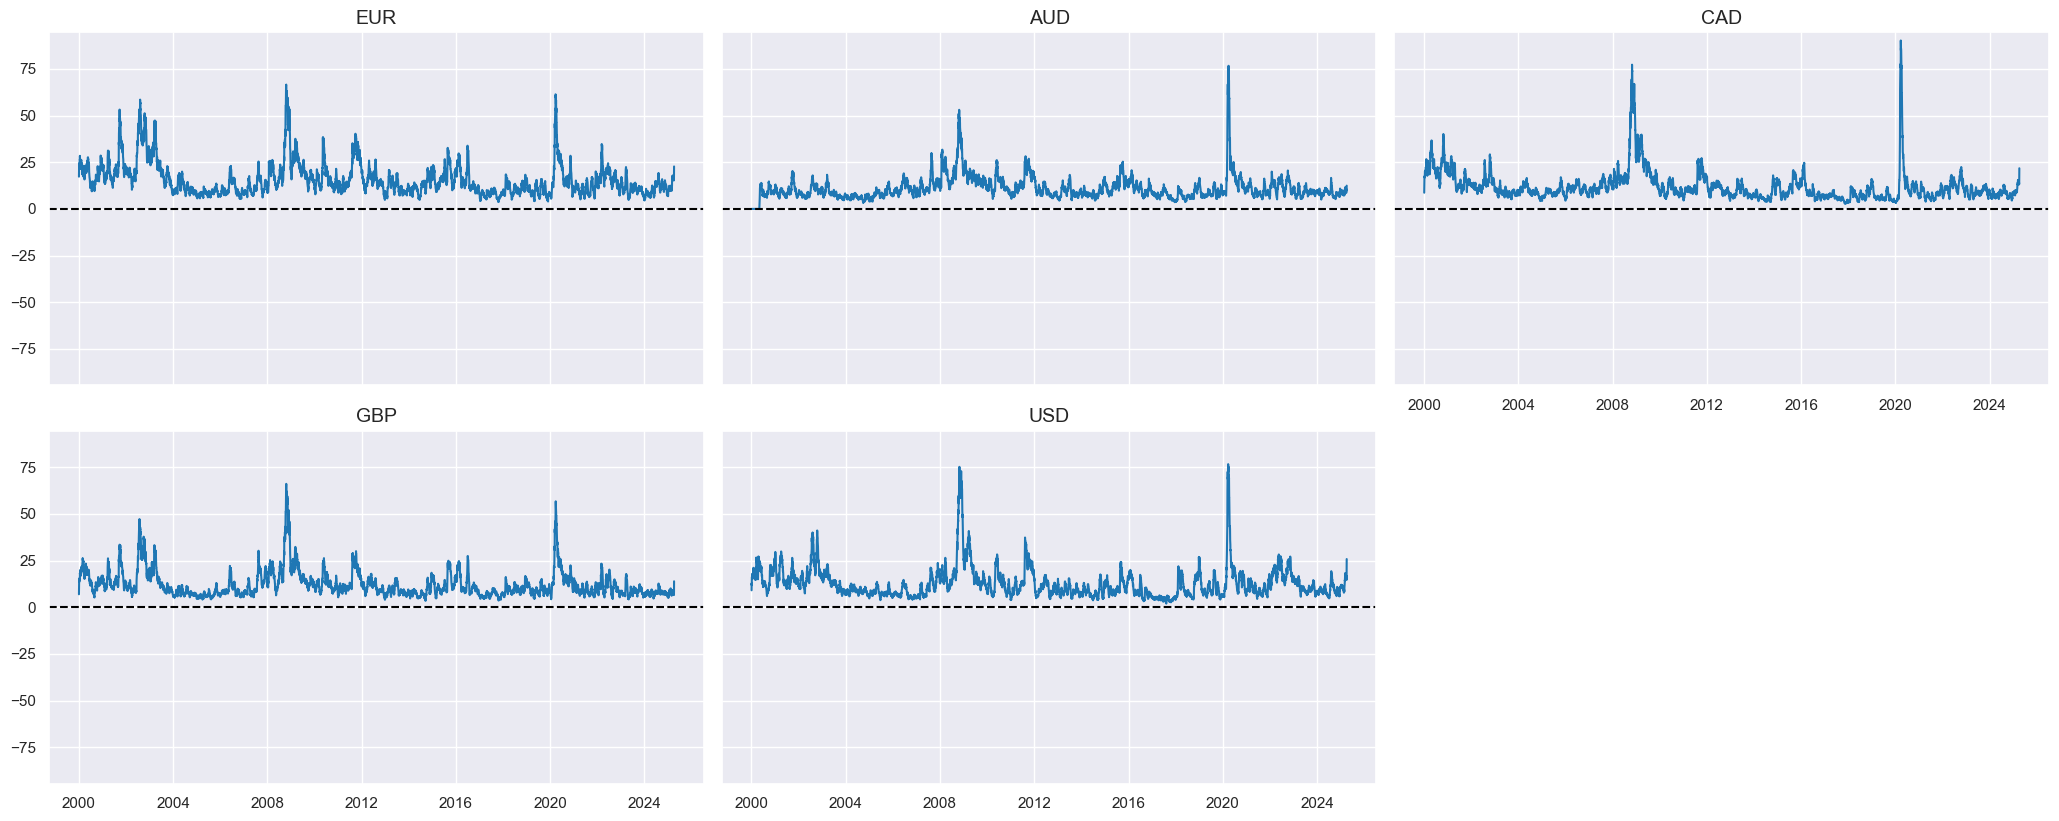

In [9]:

hdf = hv.to_pandas()

hdf = QuantamentalDataFrame.from_wide(
    (
        
        QuantamentalDataFrame(hdf)
        .to_wide()
        .reindex(
            pd.bdate_range(
                start=hdf["real_date"].min(),
                end=hdf["real_date"].max(),
                freq="B",
            ),
            method="ffill",
        )
        .dropna(axis="rows", how="all")
    ).sort_index(),
    categorical=False,
)

view_timelines(df=hdf)



In [10]:
from macrosynergy.panel.historic_vol import historic_vol

new_df_pd = QuantamentalDataFrame(
    new_df.to_pandas(), categorical=False
)
cids = new_df_pd['cid'].unique().tolist()

starttime = time.time()
hv_bench = historic_vol(
    df=new_df_pd,
    xcat='EQXR_NSA',
    cids=cids,
    lback_periods=21,
    lback_meth="xma",
    half_life=11,
    est_freq="D",
    blacklist=None,
    remove_zeros=True,
    postfix="_HV_PY",
    nan_tolerance=0.001,
)
print(f"Time taken: {time.time() - starttime}")

starttime = time.time()
a = 1 + 5
print("Time taken: ", time.time() - starttime)

Time taken: 14.346926927566528
Time taken:  0.0


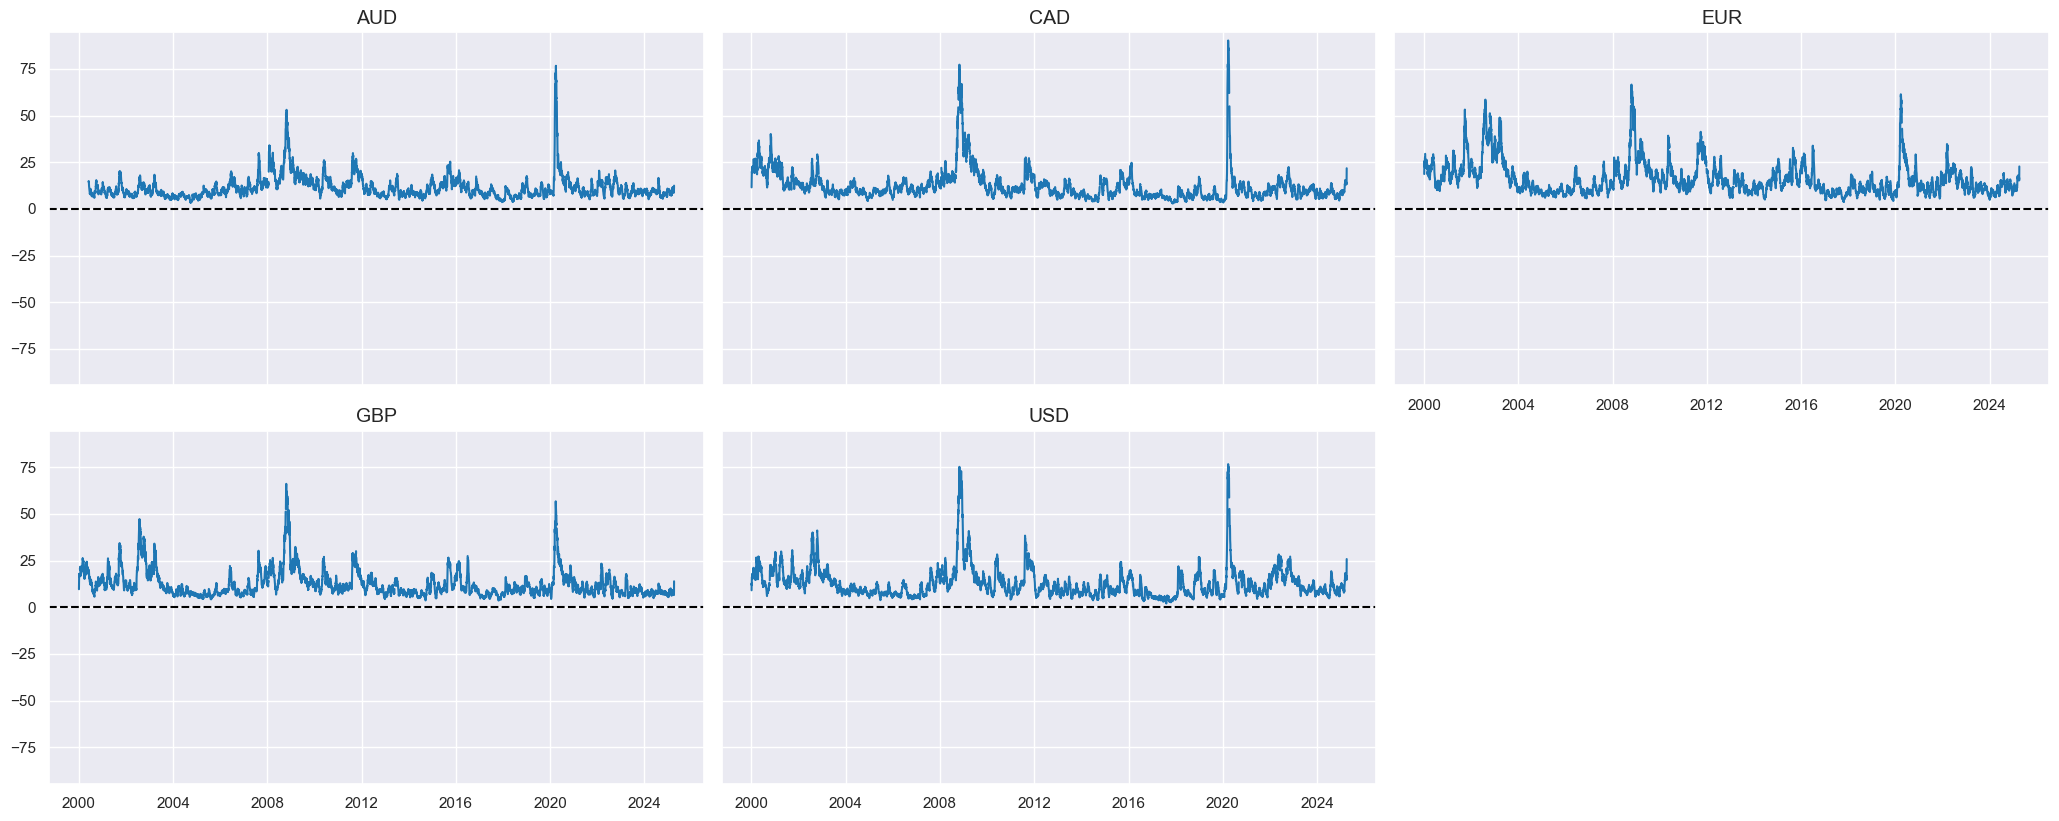

In [11]:
view_timelines(df=hv_bench)

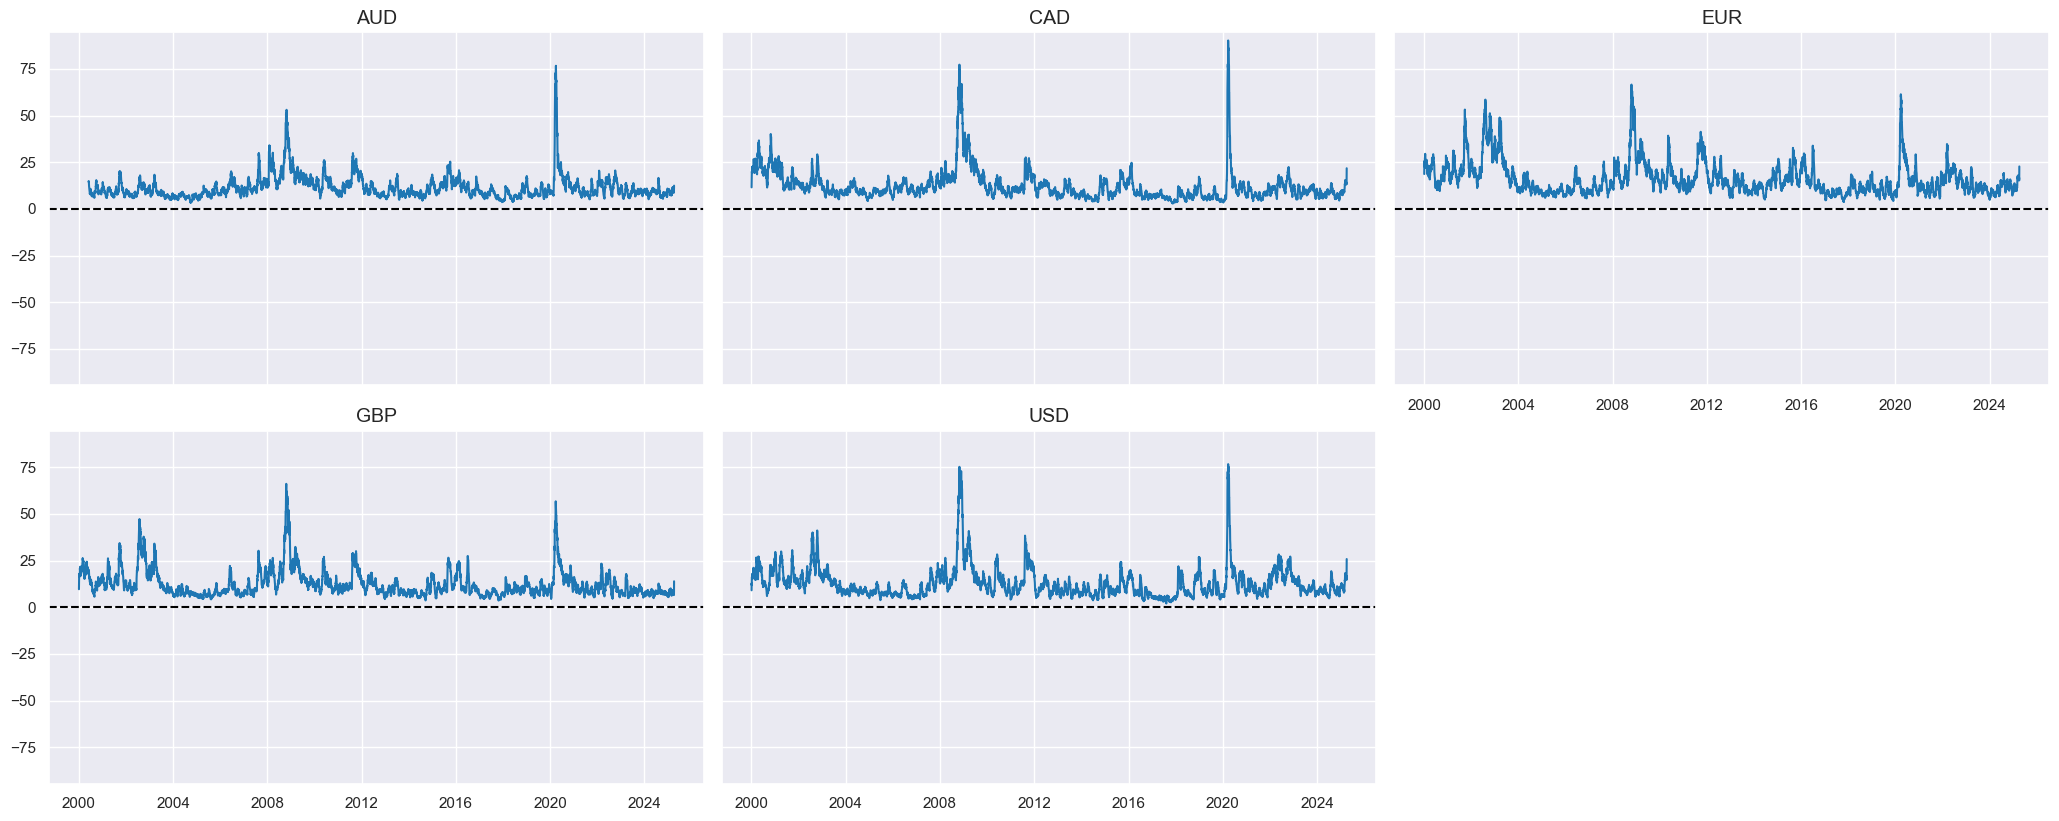

In [12]:
hv_bench = hv_bench.dropna(axis="rows", how="any").reset_index(drop=True)
bdr = pd.bdate_range(new_df_pd.real_date.min(), new_df_pd.real_date.max())
hv_bench = QuantamentalDataFrame.from_wide(
    QuantamentalDataFrame(hv_bench).to_wide().reindex(bdr, method="ffill"),
    categorical=False,
).reset_index(drop=True)

view_timelines(df=hv_bench)

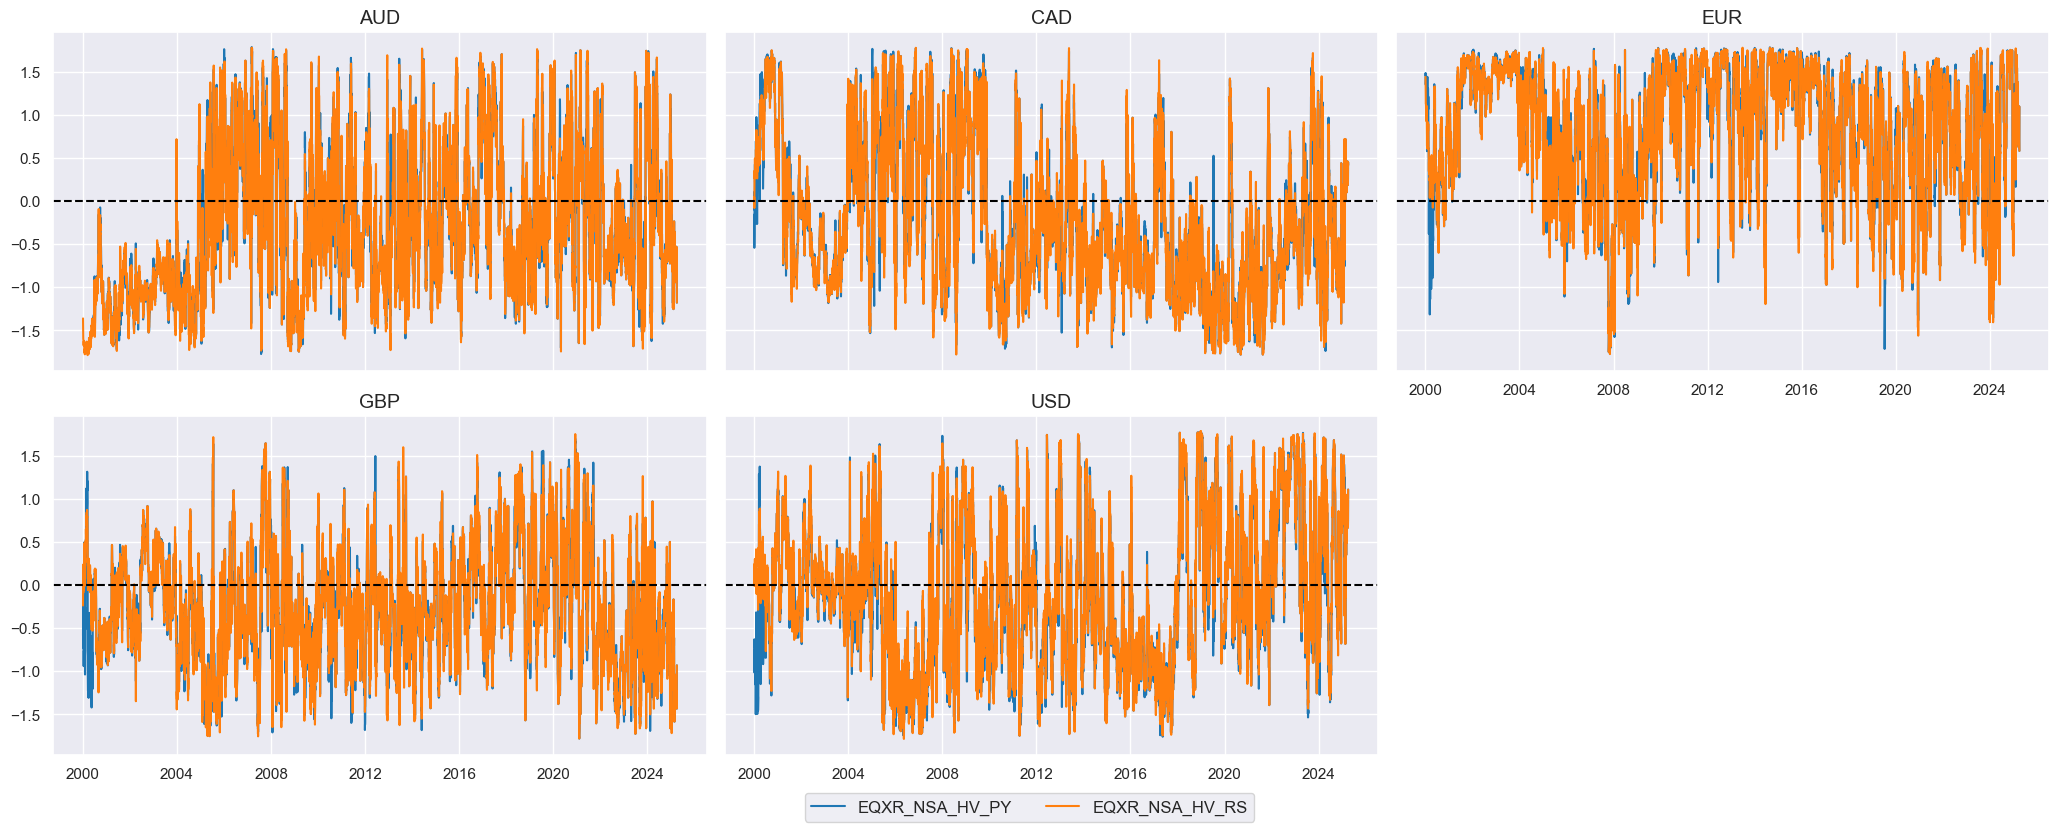

In [13]:
def zscore_series(s: pd.Series) -> pd.Series:
    return (s - s.mean()) / s.std()


a = QuantamentalDataFrame.from_wide(
    QuantamentalDataFrame(hv_bench)
    .to_wide()
    .apply(lambda x: zscore_series(x), axis=1, result_type="expand")
)

b = QuantamentalDataFrame.from_wide(
    QuantamentalDataFrame(hdf)
    .to_wide()
    .apply(lambda x: zscore_series(x), axis=1, result_type="expand")
)

view_timelines(QuantamentalDataFrame.from_qdf_list([a, b]).dropna(axis="rows", how="any").reset_index(drop=True))


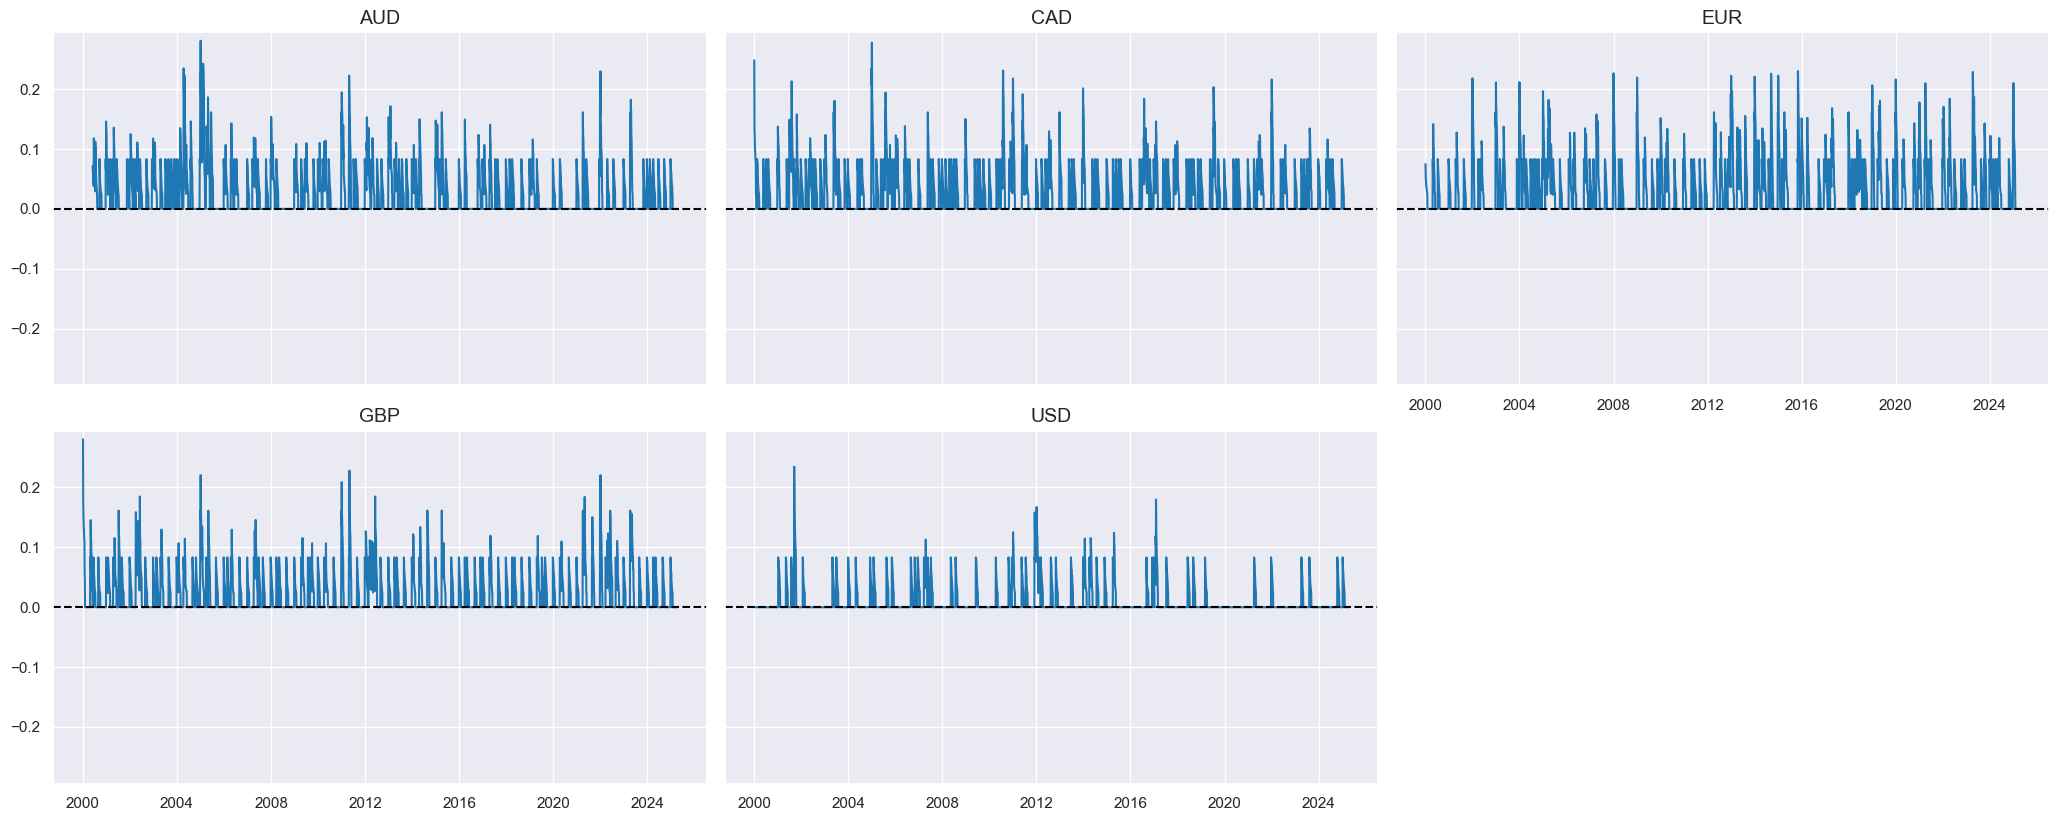

In [14]:
# a = QuantamentalDataFrame(hv_bench).to_wide().apply(lambda x: zscore_series(x), axis=1, result_type="expand").rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

# b = QuantamentalDataFrame(hdf).to_wide().apply(lambda x: zscore_series(x), axis=1, result_type="expand").rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

a = QuantamentalDataFrame(hv_bench).to_wide().rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

b = QuantamentalDataFrame(hdf).to_wide().rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

diff = (a.abs() - b.abs()).abs() / (a.abs())

view_timelines(QuantamentalDataFrame.from_wide(diff))

In [15]:
end_time = time.time()
print(f"Time taken: {end_time - nb_start_time} seconds")

Time taken: 19.609023094177246 seconds
